In [1]:
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics import classification_report

In [2]:
import openai
# TODO: not hard code
openai.api_key = open("/mnt/clbp/.openai_api_key.txt").read().strip()

In [3]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Dataset Preprocessing

In [6]:
df = pd.read_csv("../datasets/4labelers.csv").sample(frac=1)
df["four"] = (full_df["Num M (4 labelers)"] == 4).astype(int)

In [7]:
def get_noun_chunk(row):
    sent, entity = row[1], row[0]
    doc = nlp(sent)
    for chunk in doc.noun_chunks:
        if chunk.text.lower().find(entity.lower()) != -1:
            return chunk.text
    return entity

def get_root_chunk(row):
    sent, entity = row[1], row[0]
    doc = nlp(sent)
    for chunk in doc.noun_chunks:
        if chunk.text.lower().find(entity.lower()) != -1:
            return chunk.root.text
    return entity

In [8]:
df["Chunk A"] = df[["Entity A", "Sentence A"]].transpose().apply(get_noun_chunk, axis=0)
df["Chunk B"] = df[["Entity B", "Sentence B"]].transpose().apply(get_noun_chunk, axis=0)
df["Root A"] = df[["Entity A", "Sentence A"]].transpose().apply(get_root_chunk, axis=0)
df["Root B"] = df[["Entity B", "Sentence B"]].transpose().apply(get_root_chunk, axis=0)

/tmp/ipykernel_254425/535872699.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sent, entity = row[1], row[0]
/tmp/ipykernel_254425/535872699.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sent, entity = row[1], row[0]
/tmp/ipykernel_254425/535872699.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sent, entity = row[1], row[0]
/tmp/ipykernel_254425/535872699.py:10: FutureWarning: Series.__getitem__ treating keys as pos

# GPT Prompts

In [17]:
def GPT_sentence(term1, sent1, term2, sent2):
    PROMPT = "You are a healthcare professional who specializes in chronic pain. This chat thread will be used to predict entity resolution between two entities and their given context. Each entity will be given as a word and the sentence that it came from. Be sure to consider the context of the entity when labeling each entity pair. These are your labeling instructions: identify the label that best represents the given pair of entities: Matching - the two entities are identical or very closely similar in contextual meaning, and could be combined without losing information such that the two entities could be swapped in their respective sentences and would still hold the same definition in the context of the sentence. Not Matching - the two entities are not the same in context, even though they may be similar or related. A “not matching” indicates entities which do not fit the criteria to be labeled as “matching”. Output ONLY a 'yes' for matching, and ONLY a 'no' if they do not match."
    max_tokens = 4097
    relevant_paragraphs = []
    non_relevant_paragraphs = []
    messages=[
          {"role": "system", "content": PROMPT},
          {"role": "user", "content": "The first sentence and entity: A. %s, '%s'.\n The second sentence and entity: 2. %s, '%s'"%(sent1, term1, sent2, term2) }
    ]
    finished = False
    c = 1
    while not finished:
        if c > 3:
            break
        if c > 1:
            print(f"Trying openai for {c} time")
        try:
            response = openai.ChatCompletion.create(
              model="gpt-3.5-turbo",
              messages=messages,
              temperature=0,
              top_p=1,
              frequency_penalty=0,
              presence_penalty=0
            )
            finished = True
        except Exception as e:
            print(e)
        c += 1
    
    if finished:
        response = response['choices'][0]['message']['content'].strip()
        try:
            if response.find("yes") != -1:
                response = 1
            else:
                response = 0
        except Exception as e:
            print(e)
            response = 0
        return response
    else:
        return None


In [20]:
def GPT_compare_terms(term1, term2):
    PROMPT = "You are a healthcare professional who specializes in chronic pain. Here are your labeling instructions: identify the category that best represents the given pair of entities. Matching - the two entities are identical or very closely similar in contextual meaning, and could be used interchangeably without losing information. Not Matching - the two entities are not the same in context and cannot be used interchangeably, even though they may be similar or related. Ignore grammar and puntuation. Output ONLY a 'yes' for matching, and ONLY a 'no' if they do not match."
            
    max_tokens = 4097
    relevant_paragraphs = []
    non_relevant_paragraphs = []
    messages=[
          {"role": "system", "content": PROMPT},
          {"role": "user", "content": "1. %s\n2. %s"%(term1,term2) }
    ]
    finished = False
    c = 1
    while not finished:
        if c > 3:
            break
        if c > 1:
            print(f"Trying openai for {c} time")
        try:
            response = openai.ChatCompletion.create(
              model="gpt-3.5-turbo",
              messages=messages,
              temperature=0,
              top_p=1,
              frequency_penalty=0,
              presence_penalty=0
            )
            finished = True
        except Exception as e:
            print(e)
        c += 1
    
    if finished:
        response = response['choices'][0]['message']['content'].strip()
        try:
            if response.find("yes") != -1:
                response = 1
            else:
                response = 0
        except Exception as e:
            print(e)
            response = 0
        return response
    else:
        return None


# Entity Resolution Outputs

In [12]:
def compare_roots(row):
    rootA, rootB = row["Root A"], row["Root B"]
    return GPT_compare_terms(rootA, rootB)
    
if "Roots" in df.columns:
    df = df.drop(columns=["Roots"])
df["Roots"] = df.apply(compare_roots, axis=1)

In [13]:
def compare_chunks(row):
    chunkA, chunkB = row["Chunk A"], row["Chunk B"]
    return GPT_compare_terms(chunkA, chunkB)
    
if "Chunks" in df.columns:
    df = df.drop(columns=["Chunks"])
df["Chunks"] = df.apply(compare_chunks, axis=1)

In [21]:
def compare_entities(row):
    entityA, entityB = row["Entity A"], row["Entity B"]
    return GPT_compare_terms(entityA, entityB)
    
if "Entities" in df.columns:
    df = df.drop(columns=["Entities"])
df["Entities"] = df.apply(compare_entities, axis=1)

In [22]:
def compare_context(row):
    entityA, entityB = row["Entity A"], row["Entity B"]
    sentA, sentB = row["Sentence A"], row["Sentence B"]
    return GPT_sentence(entityA, sentA, entityB, sentB)
    
if "Context" in df.columns:
    df = df.drop(columns=["Context"])
df["Context"] = df.apply(compare_context, axis=1)

# Determining whether context is needed

In [131]:
def context_type(row):
    entityA, chunkA = row["Entity A"], row["Chunk A"]
    entityB, chunkB = row["Entity B"], row["Chunk B"]
    A = GPT_entities_helper(entityA, chunkA) == 1
    B = GPT_entities_helper(entityB, chunkB) == 1
    if A and B:
        return 0
    elif not A and B:
        return 1
    elif A and not B:
        return 1
    else:
        return 2
if "ContextType" in df.columns:
    df = df.drop(columns=["ContextType"])
df["ContextType"] = df.apply(context_type, axis=1)

The server is overloaded or not ready yet.
Trying openai for 2 time


In [132]:
def ModContext(row):
    entityA, rootA = row["Entity A"], row["Root A"]
    entityB, rootB = row["Entity B"], row["Root B"]
    context = row["ContextType"]
    if context == 0:
        return row["Entities"]
    elif context == 1:
        return row["Roots"]
    else:
        return row["Roots"]
if "ModifiedContext" in df.columns:
    df = df.drop(columns=["ModifiedContext"])
df["ModifiedContext"] = df.apply(ModContext, axis=1)

In [152]:
def check_positives(row):
    if row["Entities"]:
        return row["ModifiedContext"]
    return 0
if "Combined" in df.columns:
    df = df.drop(columns=["Combined"])
df["Combined"] = df.apply(check_positives, axis=1)

# Run a 100 times for safe measure

In [237]:
entities = []
context = []
chunks = []
roots = []
modifiedContext = []
combined = []

entities_res = []
context_res = []
chunks_res = []
roots_res = []
modifiedContext_res = []
combined_res = []

In [ ]:
from sklearn.metrics import f1_score

for i in range(50):
    methods = ["Entities", "Context", "Chunks", "Roots", "ContextType", "ModifiedContext", "Combined"]
    for M in methods:
        if M in df.columns:
            df = df.drop(columns=[M])
            
    df["Roots"] = df.apply(compare_roots, axis=1)
    df["Entities"] = df.apply(compare_entities, axis=1)
    df["Chunks"] = df.apply(compare_chunks, axis=1)
    df["Context"] = df.apply(compare_context, axis=1)
    df["ContextType"] = df.apply(context_type, axis=1)
    df["ModifiedContext"] = df.apply(ModContext, axis=1)
    df["Combined"] = df.apply(check_positives, axis=1)
    
    entities.append(f1_score(df["Entities"], df["four"]))
    context.append(f1_score(df["Context"], df["four"]))
    chunks.append(f1_score(df["Chunks"], df["four"]))
    roots.append(f1_score(df["Roots"], df["four"]))
    modifiedContext.append(f1_score(df["ModifiedContext"], df["four"]))
    combined.append(f1_score(df["Combined"], df["four"]))

    entities_res.append(df["Entities"])
    context_res.append(df["Context"])
    chunks_res.append(df["Chunks"])
    roots_res.append(df["Roots"])
    modifiedContext_res.append(df["ModifiedContext"])
    combined_res.append(df["Combined"])

In [ ]:
entities

In [ ]:
print("hi")

# Results

In [134]:
from sklearn.metrics import classification_report

In [153]:
methods = ["Entities", "Context", "Chunks", "Roots", "ModifiedContext", "Combined"]
res = []

for M in methods:
    metrics = classification_report(df["four"], df[M], output_dict=True, target_names=["Not Matching", "Matching"])["Matching"]
    res.append(metrics)

In [230]:
results = pd.DataFrame(res, index=predictions).drop(columns=["support"])
results = results.transpose()
print(results.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Entities & Context & Chunks & Roots & ModifiedContext & Combined \\
\midrule
precision & 0.480000 & 0.206250 & 0.395349 & 0.333333 & 0.482143 & 0.586957 \\
recall & 0.947368 & 0.868421 & 0.447368 & 0.684211 & 0.710526 & 0.710526 \\
f1-score & 0.637168 & 0.333333 & 0.419753 & 0.448276 & 0.574468 & 0.642857 \\
\bottomrule
\end{tabular}



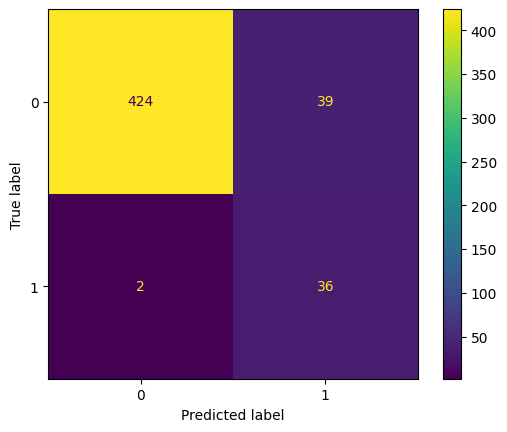

In [155]:
import matplotlib as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

entities_cm = confusion_matrix(df["four"], df["Entities"])
ConfusionMatrixDisplay(entities_cm).plot()

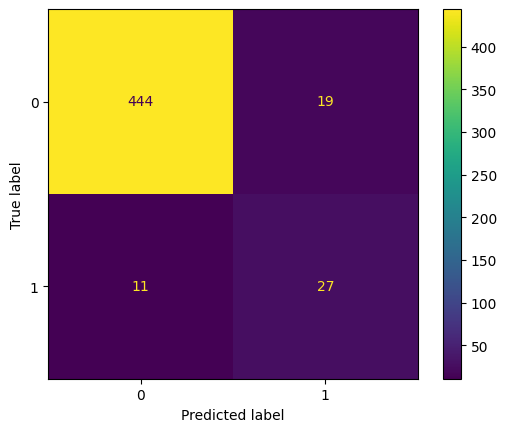

In [235]:
context_cm = confusion_matrix(df["four"], df["Combined"])
ConfusionMatrixDisplay(context_cm).plot()

# Analysis of Context vs No Context

In [210]:
root_diff = df[(df["four"] == df["Roots"]) & (df["four"] != df["Entities"])][["ContextType"]].value_counts().to_frame()

In [211]:
entities_diff = df[(df["four"] != df["Roots"]) & (df["four"] == df["Entities"])][["ContextType"]].value_counts().to_frame()

In [219]:
context_vs_entities = pd.concat([entities_diff, root_diff], axis=1)
context_vs_entities.columns = ["Entities", "Roots"]
context_vs_entities.index = ["No Context Needed", "Some Context Needed", "Context Needed"]
context_vs_entities

,Entities,Roots
No Context Needed,26,2
Some Context Needed,15,12
Context Needed,4,8


In [220]:
methods = ["Entities", "Context", "Chunks", "Roots", "ModifiedContext", "Combined"]
val_counts = []
for M in methods:
    val_counts.append(df[(df["four"] == df[M])][["ContextType"]].value_counts())

In [225]:
method_comparison = pd.concat(val_counts, axis=1)
method_comparison.columns = methods
method_comparison.index = ["No Context Needed", "Some Context Needed", "Context Needed"]
method_comparison

,Entities,Context,Chunks,Roots,ModifiedContext,Combined
No Context Needed,213,165,213,189,213,213
Some Context Needed,183,150,175,180,180,187
Context Needed,64,54,66,68,68,71
